In [3]:
pip install fatpack


Defaulting to user installation because normal site-packages is not writeable
  Using cached fatpack-0.7.8-py3-none-any.whl.metadata (3.7 kB)
Using cached fatpack-0.7.8-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import fatpack
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)
print(fatpack.__version__)

0.7.8


First we generate a signal for the example and extract the rainflow cycles and corresponding means.

In [7]:
y = np.random.normal(size=100000)*10.

S, Sm = fatpack.find_rainflow_ranges(y, return_means=True, k=256)

then create the bins to sort the range and mean values into.

In [11]:
rowbin = np.linspace(-25, 25, 50)
colbin = np.linspace(0, 85, 50)

finally we create a data array which is contains the mean values in the first column adn the range values in the second and extract the rainflow matrix. The mean-range rainflow matrix is then plotted with matplotlib.

Text(0, 0.5, 'Range')

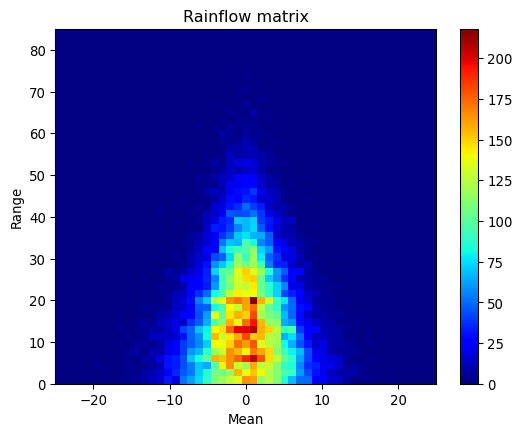

In [14]:
data_arr = np.array([Sm, S]).T
rfcmat = fatpack.find_rainflow_matrix(data_arr, rowbin, colbin)

X, Y = np.meshgrid(rowbin, colbin, indexing='ij')
plt.figure(dpi=96)
C = plt.pcolormesh(X, Y, rfcmat, cmap='jet')
plt.colorbar(C)
plt.title("Rainflow matrix")
plt.xlabel("Mean")
plt.ylabel("Range")

Start vs destination level rainflow matrix
For this rainflow matrix we must extract the cycles directly such that the start and destination point is known, we therefore begin by extracting all cycles from y.

In [17]:
rev, ix = fatpack.find_reversals(y, k=256)
cyc1, res = fatpack.find_rainflow_cycles(rev)
rev_res = fatpack.concatenate_reversals(res, res)
cyc_res, _ = fatpack.find_rainflow_cycles(rev_res)
cycles = np.concatenate((cyc1, cyc_res))

we then create bins, in this case the range (min-max) the starting level and the destination level are the same and row and column bins are the same. Finish off by plotting the result with matplotlib.

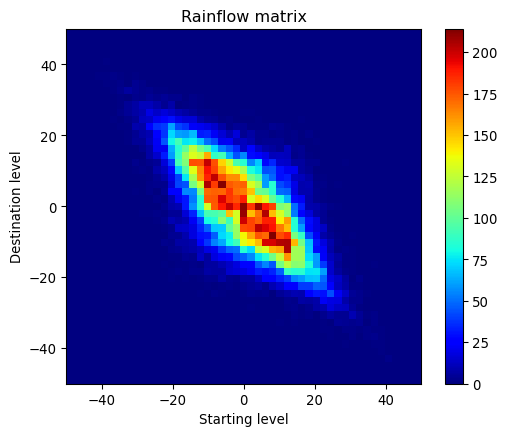

In [20]:
bins = np.linspace(-50, 50, 50)
rfcmat = fatpack.find_rainflow_matrix(cycles, bins, bins)

X, Y = np.meshgrid(bins, bins, indexing='ij')
plt.figure(dpi=96)
C = plt.pcolormesh(X, Y, rfcmat, cmap='jet')
plt.colorbar(C)
plt.title("Rainflow matrix")
plt.xlabel("Starting level")
plt.ylabel("Destination level")
plt.gca().set_aspect('equal')

2. DNVGL RP-C203 endurance curves with fatpack

In [23]:
import fatpack
import numpy as np
import matplotlib.pyplot as plt
print(fatpack.__version__)

0.7.8


DNVGL-RP-C203（现已更名为 DNV-RP-C203) 是挪威船级社（DNV）发布的推荐规程，标题为“疲劳设计钢结构”。 它提供了一种方法和指导，用于评估和设计承受循环载荷的海洋和陆上钢结构的疲劳强度。

主要内容包括：

S-N曲线: C203 提供了广泛的 S-N 曲线（应力-寿命曲线），涵盖各种焊接细节、材料等级和环境条件。这些曲线是基于大量的疲劳试验数据得出的，用于预测结构细节在特定应力范围下的疲劳寿命。

疲劳评估方法: 该规程描述了基于 S-N 曲线的疲劳评估方法，包括名义应力法和热点应力法，以及如何考虑焊接细节的影响。

载荷谱: C203 提供了指导，说明如何定义代表结构在其使用寿命期间所经历的循环载荷的载荷谱。

疲劳损伤累积: 该规程介绍了 Miner 线性累积损伤法则，用于评估由不同应力范围的循环载荷引起的累积疲劳损伤。

环境影响: C203 考虑了腐蚀等环境因素对疲劳强度的影响。

设计考虑: 该规程提供了设计建议，以提高结构的疲劳性能，例如选择合适的焊接细节和避免应力集中。

适用范围：

DNV-RP-C203 广泛应用于海洋和陆上钢结构的设计，包括：

海上平台

船舶

风力涡轮机

桥梁

起重机

与其他标准的关系：

DNV-RP-C203 与其他疲劳设计标准（如 Eurocode 3 和 API RP 2A）有一些相似之处，但也存在一些差异。 因此，在应用时，务必仔细查阅相关标准并根据具体项目要求选择合适的标准。

总结：

DNV-RP-C203 是疲劳设计钢结构的重要参考文件，它提供了基于 S-N 曲线的实用方法，用于评估和设计承受循环载荷的结构，并考虑了各种影响因素，例如焊接细节、材料等级和环境条件。 它在海洋和陆上工程领域得到广泛应用，有助于确保结构的安全性和可靠性。

To define this curve in fatpack, we first define a curve with characteristic stress (detail category) Sc=1.0 and then alter the characteristic endurance Nc, slopes m1,m2 and then finally the intersect Nd, see below

Example: Defining DNVGL C203 endurance curve C (in air) in fatpack

In [31]:
curve = fatpack.BiLinearEnduranceCurve(1.0)
curve.Nc = 10.**12.592
curve.m1 = 3.0
curve.m2 = 5.0
curve.Nd = 1e7

Fatigue limit: 73
Intercept of second linear curve log a2: 16.32


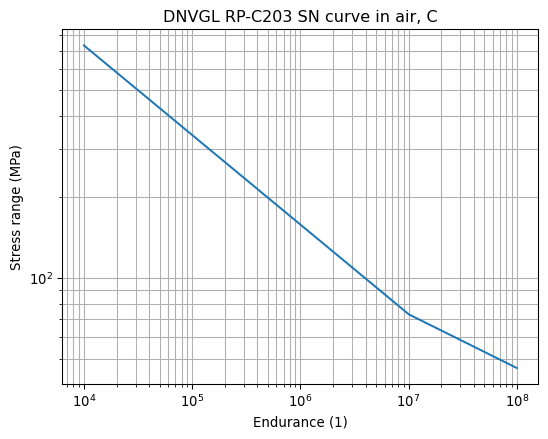

In [33]:
N = np.logspace(4, 8, 1000)
S = curve.get_stress(N)

plt.figure(dpi=96)
plt.loglog(N, S)
plt.title("DNVGL RP-C203 SN curve in air, C")
plt.xlabel("Endurance (1)")
plt.ylabel("Stress range (MPa)")
plt.grid(which='both')


fatigue_limit = curve.get_stress(10**7)
print("Fatigue limit:", fatigue_limit)

loga2 = np.log10(curve.get_endurance(1.0))
print("Intercept of second linear curve log a2:", loga2)

1. Defining a DNVGL endurance curve factory class
1.1 Below we define the DNVGL endurance curves for "in air", "in seawater with cathodic protection" and "in seawater for free corrosion" and create a factory class to for easy access to the different SN curves.

In [37]:
curves_in_air = dict(
    reference = "DNVGL-RP-C203 - Edition April 2016, Table 2-1 S-N curves in air",
    B1= dict(m1=4.0, loga1=15.117, m2=5, Nd=1e7, loga2=17.146, fl=106.97),
    B2= dict(m1=4.0, loga1=14.885, m2=5, Nd=1e7, loga2=16.856, fl= 93.59),
    C = dict(m1=3.0, loga1=12.592, m2=5, Nd=1e7, loga2=16.320, fl= 73.10),
    C1= dict(m1=3.0, loga1=12.449, m2=5, Nd=1e7, loga2=16.081, fl= 65.50),
    C2= dict(m1=3.0, loga1=12.301, m2=5, Nd=1e7, loga2=15.835, fl= 58.48),
    D = dict(m1=3.0, loga1=12.164, m2=5, Nd=1e7, loga2=15.606, fl= 52.63),
    E = dict(m1=3.0, loga1=12.010, m2=5, Nd=1e7, loga2=15.350, fl= 46.78),
    F = dict(m1=3.0, loga1=11.855, m2=5, Nd=1e7, loga2=15.091, fl= 41.52),
    F1= dict(m1=3.0, loga1=11.699, m2=5, Nd=1e7, loga2=14.832, fl= 36.84),
    F3= dict(m1=3.0, loga1=11.546, m2=5, Nd=1e7, loga2=14.576, fl= 32.75),
    G = dict(m1=3.0, loga1=11.398, m2=5, Nd=1e7, loga2=14.330, fl= 29.24),
    W1= dict(m1=3.0, loga1=11.261, m2=5, Nd=1e7, loga2=14.101, fl= 26.32),
    W2= dict(m1=3.0, loga1=11.107, m2=5, Nd=1e7, loga2=13.845, fl= 23.39),
    W3= dict(m1=3.0, loga1=10.970, m2=5, Nd=1e7, loga2=13.617, fl= 21.05),
)
curves_in_seawater_with_cathodic_protection = dict(
    reference = "DNVGL-RP-C203 - Edition April 2016, Table 2-2 S-N curves in air",
    B1= dict(m1=4.0, loga1=14.917, m2=5, Nd=1e6, loga2=17.146, fl=106.97),
    B2= dict(m1=4.0, loga1=14.685, m2=5, Nd=1e6, loga2=16.856, fl= 93.59),
    C = dict(m1=3.0, loga1=12.192, m2=5, Nd=1e6, loga2=16.320, fl= 73.10),
    C1= dict(m1=3.0, loga1=12.049, m2=5, Nd=1e6, loga2=16.081, fl= 65.50),
    C2= dict(m1=3.0, loga1=11.901, m2=5, Nd=1e6, loga2=15.835, fl= 58.48),
    D = dict(m1=3.0, loga1=11.764, m2=5, Nd=1e6, loga2=15.606, fl= 52.63),
    E = dict(m1=3.0, loga1=11.610, m2=5, Nd=1e6, loga2=15.350, fl= 46.78),
    F = dict(m1=3.0, loga1=11.455, m2=5, Nd=1e6, loga2=15.091, fl= 41.52),
    F1= dict(m1=3.0, loga1=11.299, m2=5, Nd=1e6, loga2=14.832, fl= 36.84),
    F3= dict(m1=3.0, loga1=11.146, m2=5, Nd=1e6, loga2=14.576, fl= 32.75),
    G = dict(m1=3.0, loga1=10.998, m2=5, Nd=1e6, loga2=14.330, fl= 29.24),
    W1= dict(m1=3.0, loga1=10.861, m2=5, Nd=1e6, loga2=14.101, fl= 26.32),
    W2= dict(m1=3.0, loga1=10.707, m2=5, Nd=1e6, loga2=13.845, fl= 23.39),
    W3= dict(m1=3.0, loga1=10.570, m2=5, Nd=1e6, loga2=13.617, fl= 21.05),
    )

curves_in_seawater_for_free_corrosion = dict(
    reference = "DNVGL-RP-C203 - Edition April 2016, Table 2-4 S-N curves in air",
    B1= dict(m=3.0, loga=12.436),
    B2= dict(m=3.0, loga=12.262),
    C = dict(m=3.0, loga=12.115),
    C1= dict(m=3.0, loga=11.972),
    C2= dict(m=3.0, loga=11.824),
    D = dict(m=3.0, loga=11.687),
    E = dict(m=3.0, loga=11.533),
    F = dict(m=3.0, loga=11.378),
    F1= dict(m=3.0, loga=11.222),
    F3= dict(m=3.0, loga=11.068),
    G = dict(m=3.0, loga=10.921),
    W1= dict(m=3.0, loga=10.784),
    W2= dict(m=3.0, loga=10.630),
    W3= dict(m=3.0, loga=10.493),
)
class DNVGL_EnduranceCurve:
    """Return a DNVGL C203 endurance curve.
    
    Use the following methods to access endurance curves 
    for different structural types and in different environments
        - DNVGL_EnduranceCurve.in_air
        - DNVGL_EnduranceCurve.in_seawater_with_cathodic_protection
        - DNVGL_EnduranceCurve.in_seawater_for_free_corrosion
        
    """
    names = [c for c in curves_in_air.keys() if c != "reference"]
    @staticmethod
    def in_air(name):
        """Returns a DNVGL endurance curve (SN curve)
        
        This method returns an endurance curve in air according to 
        table 2-1 in DNVGL RP-C203.
        
        Arguments
        ---------
        name : str
            Name of the endurance curve.
            
        Returns
        -------
        fatpack.BiLinearEnduranceCurve
            Endurance curve corresponding to `name` in DNVGL RP-C203
            
        Example
        -------
        >>>curve = DNVGL_EnduranceCurve.in_air("D")
        >>>N = curve.get_endurance(90.0)
        
        """
        
        data = curves_in_air[name]
        curve = fatpack.BiLinearEnduranceCurve(1.0)
        curve.Nc = 10 ** data["loga1"]
        curve.Nd = data["Nd"]
        curve.m1 = data["m1"]
        curve.m2 = data["m2"]
        curve.reference = curves_in_air["reference"]
        return curve
    
    @staticmethod
    def in_seawater_with_cathodic_protection(name):
        """Returns a DNVGL endurance curve (SN curve)
        
        This method returns an endurance curve in seawater with 
        cathodic protection according to table 2-2 in DNVGL RP-C203.
        
        Arguments
        ---------
        name : str
            Name of the endurance curve.
            
        Returns
        -------
        fatpack.BiLinearEnduranceCurve
            Endurance curve corresponding to `name` in DNVGL RP-C203
            
        Example
        -------
        >>>curve = DNVGL_EnduranceCurve.in_seawater_with_cathodic_protection("D")
        >>>N = curve.get_endurance(90.0)

        """
        data = curves_in_seawater_with_cathodic_protection[name]
        curve = fatpack.BiLinearEnduranceCurve(1.0)
        curve.Nc = 10 ** data["loga1"]
        curve.Nd = data["Nd"]
        curve.m1 = data["m1"]
        curve.m2 = data["m2"]
        ref = curves_in_seawater_with_cathodic_protection["reference"]
        curve.reference = ref
        return curve
    
    @staticmethod
    def in_seawater_for_free_corrosion(name):
        """Returns a DNVGL endurance curve (SN curve)
        
        This method returns an endurance curve in seawater for 
        free corrosion according to table 2-4 in DNVGL RP-C203.
        
        Arguments
        ---------
        name : str
            Name of the endurance curve.
            
        Returns
        -------
        fatpack.LinearEnduranceCurve
            Endurance curve corresponding to `name` in DNVGL RP-C203
            
        Example
        -------
        >>>curve = DNVGL_EnduranceCurve.in_seawater_for_free_corrosion("D")
        >>>N = curve.get_endurance(90.0)
        
        """
        data = curves_in_seawater_for_free_corrosion[name]
        curve = fatpack.LinearEnduranceCurve(1.0)
        curve.Nc = 10 ** data["loga"]
        curve.m = data["m"]
        ref = curves_in_seawater_for_free_corrosion["reference"]
        curve.reference = ref
        return curve    

Below we plot the curves and compare the fatigue limit (fl) given in C203 to the fatigue limit determined by the defined curves in fatpack.

Curve   |  Est. fl |  True fl | Fl error
B1      |   106.97 |   106.97 |    0.00%
B2      |    93.59 |    93.59 |    0.00%
C       |    73.11 |    73.10 |    0.01%
C1      |    65.51 |    65.50 |    0.02%
C2      |    58.48 |    58.48 |    0.00%
D       |    52.64 |    52.63 |    0.02%
E       |    46.77 |    46.78 |   -0.02%
F       |    41.53 |    41.52 |    0.02%
F1      |    36.84 |    36.84 |    0.00%
F3      |    32.76 |    32.75 |    0.03%
G       |    29.24 |    29.24 |    0.00%
W1      |    26.32 |    26.32 |    0.00%
W2      |    23.39 |    23.39 |    0.00%
W3      |    21.05 |    21.05 |    0.00%


(10000.0, 100000000.0)

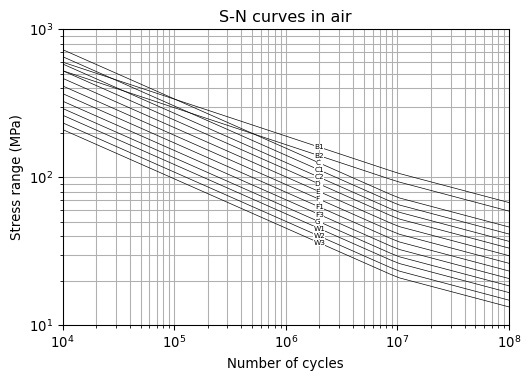

In [40]:
fig = plt.figure(dpi=96, figsize=(6, 4))

N = np.logspace(4, 8)
print("{0:<7} | {1:>8} | {2:>8} | {3:>8}".format("Curve", "Est. fl", "True fl", "Fl error"))
for name in DNVGL_EnduranceCurve.names:
    curve = DNVGL_EnduranceCurve.in_air(name)
    data = curves_in_air[name]
    fl = np.round(curve.get_stress(1e7), 2)
    fl_data = data["fl"]
    err = (fl-fl_data)/fl_data
    np.testing.assert_almost_equal(fl, fl_data, decimal=2)
    print(f"{name:<7} | {fl:8.2f} | {fl_data:8.2f} | {err:8.2%}")
    S = curve.get_stress(N)
    plt.loglog(N, S, "k", lw=.5)
    plt.text(2e6, curve.get_stress(2e6), "{0:2s}".format(name), fontsize=5.5, 
             ha='center', va='center', bbox={'fc':'w', 'ec':(0, 0, 0, 0), 'pad':0})
plt.grid(which='both')
plt.title("S-N curves in air")
plt.xlabel("Number of cycles")
plt.ylabel("Stress range (MPa)")
plt.ylim(10, 1000)
plt.xlim(1e4, 1e8)

Removing small range cycles from reversals by racetrack filtering
This notebook demonstrates how to apply the racetrack filter to remove reversals from a signal which has rainflow cycles below a certain threshold by keeping the reversal sequence intact

In [43]:
import fatpack
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)
print(fatpack.__version__)

0.7.8


First we generate a signal for the example

In [48]:
y = np.random.normal(size=100000)*10.

Reverals (peaks and valleys) can be extracted with and without a racetrack filter with fatpack, here we remove all reversals that produce a rainflow cycle below h=15.

In [51]:
rev, ix = fatpack.find_reversals(y, k=256)
rev_rtf, ix_rtf = fatpack.find_reversals_racetrack_filtered(y, h=20, k=256)

We can then plot the results, we see that the reversals which produce small rainflow ranges are removed from the filtered reversals

(30.0, 100.0)

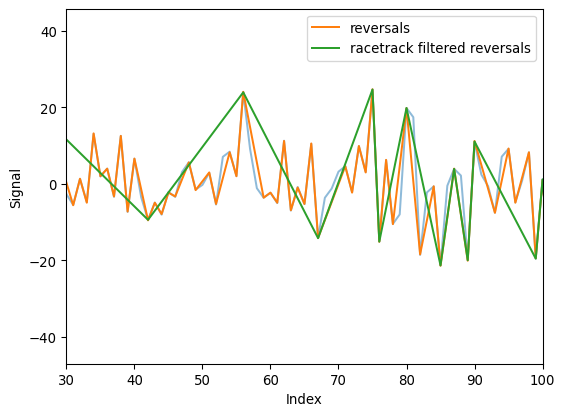

In [54]:
plt.figure(dpi=96)
plt.plot(y, alpha=.5)
plt.plot(ix, rev, label='reversals')
plt.plot(ix_rtf, rev_rtf, label='racetrack filtered reversals')
plt.legend(loc='best')
plt.xlabel("Index")
plt.ylabel("Signal")
plt.xlim(30, 100)

we can verify that all ranges below h=20 are removed by taking a look at the range-count plot or range-cumulative count plot.

Text(0, 0.5, 'Count')

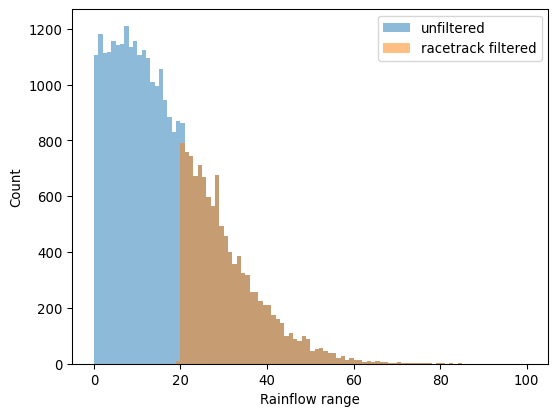

In [57]:
ranges = fatpack.find_rainflow_ranges(rev, k=256)
ranges_rtf = fatpack.find_rainflow_ranges(rev_rtf, k=256)
bins = np.linspace(0, 100, 101)
N, S = fatpack.find_range_count(ranges, bins)
N_rtf, S_rtf = fatpack.find_range_count(ranges_rtf, bins)

plt.figure(dpi=96)
plt.bar(S, N, alpha=.5, width=1, label="unfiltered")
plt.bar(S_rtf, N_rtf, alpha=.5, width=1, label="racetrack filtered")
plt.legend()
plt.xlabel("Rainflow range")
plt.ylabel("Count")

Text(0, 0.5, 'Rainflow range')

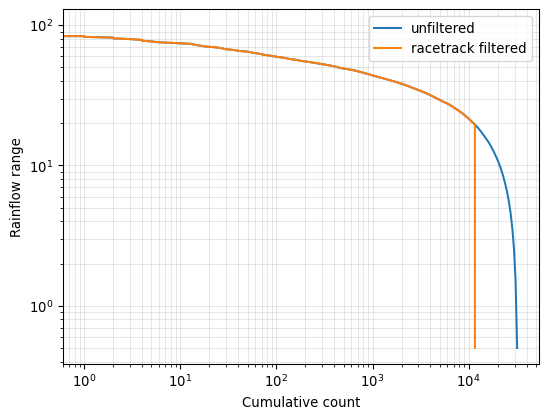

In [59]:
Ncum = N.sum() - np.cumsum(N)
Ncum_rtf = N_rtf.sum() - np.cumsum(N_rtf)

plt.figure(dpi=96)
plt.loglog(Ncum, S, label="unfiltered")
plt.loglog(Ncum_rtf, S_rtf, label="racetrack filtered")
plt.legend()
plt.grid(which='both', alpha=.3)
plt.xlabel("Cumulative count")
plt.ylabel("Rainflow range")

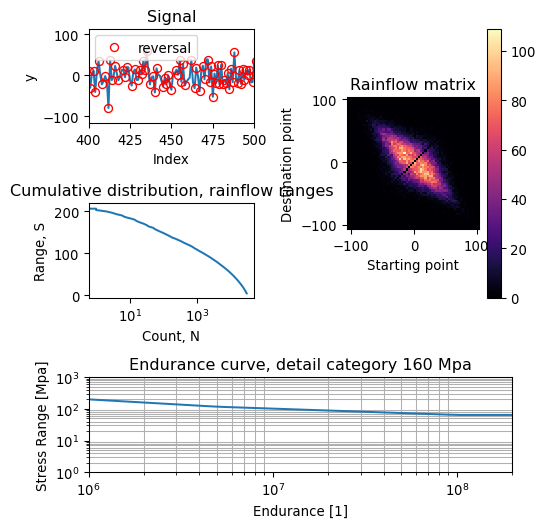

In [61]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import fatpack

np.random.seed(10)

# Generate a signal
y = np.random.normal(size=100000) * 25.

# Find reversals (peaks and valleys), extract cycles and residue (open cycle
# sequence), process and extract closed cycles from residue.
reversals, reversals_ix = fatpack.find_reversals(y)
cycles, residue = fatpack.find_rainflow_cycles(reversals)
processed_residue = fatpack.concatenate_reversals(residue, residue)
cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
cycles_total = np.concatenate((cycles, cycles_residue))

# Find the rainflow ranges from the cycles
ranges = np.abs(cycles_total[:, 1] - cycles_total[:, 0])

# alternatively the rainflow ranges can be obtained from the signal directly
# by the wrapper function `find_rainflow_ranges`, i.e
# ranges = fatpack.find_rainflow_ranges(y)

figsize = np.array([140., 140.]) / 25.
fig = plt.figure(dpi=96, figsize=figsize)

# Plotting signal with reversals.
ax_signal = plt.subplot2grid((3, 2), (0, 0))
ax_signal.plot(y)
ax_signal.plot(reversals_ix, y[reversals_ix], 'ro', fillstyle='none',
               label='reversal')
ax_signal.legend()
ax_signal.set(title="Signal", ylabel="y", xlabel="Index", xlim=[400, 500])

# Plotting the cumulative distribution of the cycle count
ax_cumdist = plt.subplot2grid((3, 2), (1, 0))
N, S = fatpack.find_range_count(ranges, 64)
Ncum = N.sum() - np.cumsum(N)
ax_cumdist.semilogx(Ncum, S)
ax_cumdist.set(title="Cumulative distribution, rainflow ranges",
               xlabel="Count, N", ylabel="Range, S")

# Plotting the rainflow matrix of the total cycle count
ax_rfcmat = plt.subplot2grid((3, 2), (0, 1), rowspan=2, aspect='equal')
bins = np.linspace(cycles_total.min(), cycles_total.max(), 64)
rfcmat = fatpack.find_rainflow_matrix(cycles_total, bins, bins)
X, Y = np.meshgrid(bins, bins, indexing='ij')
C = ax_rfcmat.pcolormesh(X, Y, rfcmat, cmap='magma')
fig.colorbar(C)
ax_rfcmat.set(title="Rainflow matrix",
              xlabel="Starting point", ylabel="Destination point")

# Let us also get the EC3 endurance curve for detail category 160 and plot it.
ax = plt.subplot2grid((3, 2), (2, 0), colspan=2,)
curve = fatpack.TriLinearEnduranceCurve(160)

N = np.logspace(6, 9)
S = curve.get_stress(N)

ax.loglog(N, S)
ax.set(xlim=(1e6, 2e8), ylim=(1., 1000),
       title="Endurance curve, detail category 160 Mpa",
       xlabel="Endurance [1]", ylabel="Stress Range [Mpa]")
ax.grid()
ax.grid(which='both')
fig.tight_layout()
plt.show(block=True)

In [63]:
# 假设上述代码已定义了 N, S 和 curve 对象

# 使用 Miner 法计算累积损伤
D = 0.0
for n_i, S_i in zip(N, S):
    # 使用S-N曲线计算该应力幅 S_i 下可承受的循环数 N_i
    N_i = curve.get_endurance(S_i)
    # 累积损伤
    D += n_i / N_i

print("Cumulative Damage (D):", D)

if D >= 1.0:
    print("Predicted fatigue failure at the given loading condition.")
else:
    print("Remaining fatigue life available.")


Cumulative Damage (D): 102.12918692161008
Predicted fatigue failure at the given loading condition.


In [67]:
import numpy as np

class CustomTriLinearCurve:
    def __init__(self, 
                 N1, S1, m1, 
                 N2, S2, m2, 
                 N3, S3, m3):
        """
        参数说明（需根据您对MMPDS数据的拟合结果进行替换）:
        N1, S1, m1: 第一段终点 (N1, S1) 及该段斜率 m1
        N2, S2, m2: 第二段终点 (N2, S2) 及该段斜率 m2
        N3, S3, m3: 第三段终点 (N3, S3) 及该段斜率 m3
        
        在对数坐标下，S-N关系通常为:
        log10(N) = A - m*log10(S)

        因此需根据已知点(Ni, Si)求出对应的A值:
        A = log10(Ni) + m*log10(Si)
        不同段使用不同的A值。
        """

        self.m1 = m1
        self.m2 = m2
        self.m3 = m3

        self.N1 = N1
        self.N2 = N2
        self.N3 = N3

        self.S1 = S1
        self.S2 = S2
        self.S3 = S3

        # 根据已知点计算 A1, A2, A3
        self.A1 = np.log10(N1) + m1*np.log10(S1)
        self.A2 = np.log10(N2) + m2*np.log10(S2)
        self.A3 = np.log10(N3) + m3*np.log10(S3)

    def get_stress(self, N):
        """
        给定循环数N，求对应的应力幅S。
        按N所处区间选择对应的段进行计算。
        """
        N = np.atleast_1d(N)
        S = np.zeros_like(N, dtype=float)

        # 段1: N ≤ N1
        mask1 = (N <= self.N1)
        # log10(N) = A1 - m1*log10(S) => log10(S) = (A1 - log10(N))/m1
        S[mask1] = 10**((self.A1 - np.log10(N[mask1]))/self.m1)

        # 段2: N1 < N ≤ N2
        mask2 = (N > self.N1) & (N <= self.N2)
        S[mask2] = 10**((self.A2 - np.log10(N[mask2]))/self.m2)

        # 段3: N > N2
        mask3 = (N > self.N2)
        S[mask3] = 10**((self.A3 - np.log10(N[mask3]))/self.m3)

        return S if len(S) > 1 else S[0]

    def get_endurance(self, S):
        """
        给定应力幅S，求对应的可承受循环数N。
        按S所处区间选择对应的段进行计算。
        假设S1 > S2 > S3，并且高应力对应低寿命区域。
        """
        S = np.atleast_1d(S)
        N = np.zeros_like(S, dtype=float)

        # 假设最高应力段对应S >= S1 (短寿命)
        mask1 = (S >= self.S1)
        N[mask1] = 10**(self.A1 - self.m1*np.log10(S[mask1]))

        # 中间段 S2 ≤ S < S1
        mask2 = (S < self.S1) & (S >= self.S2)
        N[mask2] = 10**(self.A2 - self.m2*np.log10(S[mask2]))

        # 最低应力段 S < S2
        mask3 = (S < self.S2)
        N[mask3] = 10**(self.A3 - self.m3*np.log10(S[mask3]))

        return N if len(N) > 1 else N[0]

# 使用示例（参数需根据您的MMPDS数据拟合结果进行实际替换）
N1, S1, m1 = 1e5, 50, 3.0   # 假设参数
N2, S2, m2 = 1e7, 20, 5.0
N3, S3, m3 = 1e9, 10, 9.0

my_curve = CustomTriLinearCurve(N1, S1, m1, N2, S2, m2, N3, S3, m3)

# 测试调用
test_N = np.logspace(4, 9, 10)
test_S = my_curve.get_stress(test_N)
print("Calculated stresses:", test_S)

test_S_value = 30
test_endurance = my_curve.get_endurance(test_S_value)
print(f"At S={test_S_value} MPa, endurance N={test_endurance}")


Calculated stresses: [107.7217345   70.32636211  47.73179574  36.95699595  28.61445978
  22.15513701  15.31740464  13.28791343  11.52732121  10.        ]
At S=30 MPa, endurance N=1316872.42798354


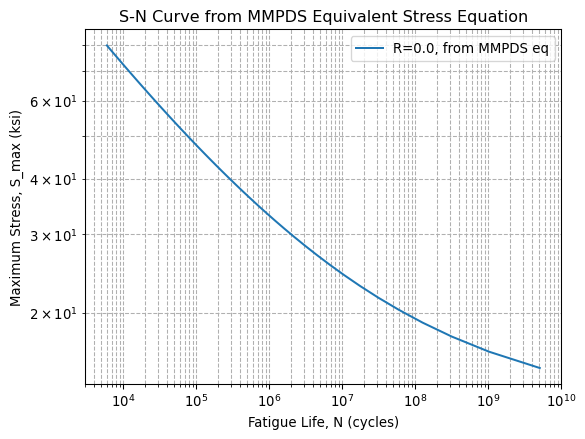

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# 已知拟合参数（示例）
A = 11.8
B = 4.38
C = 12.0

# 定义等效应力函数S_eq和寿命函数N_f
def S_eq(S_max, R):
    return S_max * (1 - R)**0.61

def fatigue_life(S_max, R):
    # 计算等效应力
    seq = S_eq(S_max, R)
    # 确保(S_eq - C) > 0，否则无效
    if np.any(seq <= C):
        # 对于seq <= C时，方程可能不适用，需要检查实际数据范围
        return np.full_like(seq, np.nan)
    # 根据公式求N_f
    logNf = A - B * np.log10(seq - C)
    Nf = 10**logNf
    return Nf

# 设定应力比R值（举例R=0）
R = 0.0

# 定义S_max的范围（单位可能为ksi，根据MMPDS数据）
S_max_values = np.linspace(15, 80, 50)  # 在15~80 ksi间取50个点
Nf_values = fatigue_life(S_max_values, R)

# 绘制S-N曲线（S_max vs Nf）
fig, ax = plt.subplots(dpi=96)
ax.loglog(Nf_values, S_max_values, label=f'R={R}, from MMPDS eq')
ax.set_xlabel('Fatigue Life, N (cycles)')
ax.set_ylabel('Maximum Stress, S_max (ksi)')
ax.set_title('S-N Curve from MMPDS Equivalent Stress Equation')
ax.grid(which='both', linestyle='--')
ax.legend()
plt.show()


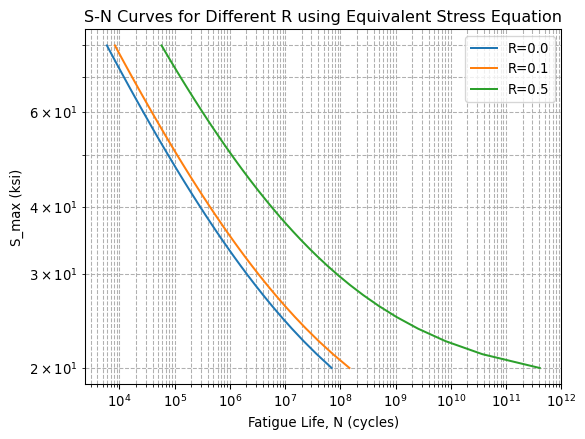

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# 给定的等效应力公式参数（例示）
A = 11.8
B = 4.38
C = 12.0
m = 0.61

def S_eq(S_max, R):
    return S_max * (1 - R)**m

def fatigue_life(S_max, R):
    # 计算等效应力
    seq = S_eq(S_max, R)
    # 检查 seq > C，否则公式不适用
    valid_mask = seq > C
    N = np.full_like(seq, np.nan)
    N[valid_mask] = 10**(A - B*np.log10(seq[valid_mask]-C))
    return N

# 假设我们想绘制R=0, R=0.1, R=0.5的S-N曲线对比
R_values = [0.0, 0.1, 0.5]
S_max_values = np.linspace(20,80,50) # ksi

fig, ax = plt.subplots(dpi=96)
for R in R_values:
    N_values = fatigue_life(S_max_values, R)
    ax.loglog(N_values, S_max_values, label=f'R={R}')

ax.set_xlabel('Fatigue Life, N (cycles)')
ax.set_ylabel('S_max (ksi)')
ax.set_title('S-N Curves for Different R using Equivalent Stress Equation')
ax.grid(which='both', linestyle='--')
ax.legend()
plt.show()


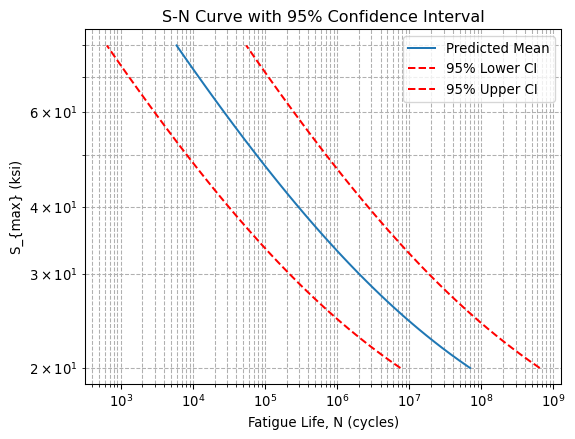

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# 假设从MMPDS获得的参数
A = 11.8
B = 4.38
C = 12.0
m = 0.61
SEE = 0.493  # 标准误差（对数寿命域）

def S_eq(S_max, R):
    return S_max * (1 - R)**m

def logN_pred(S_max, R):
    seq = S_eq(S_max, R)
    # 确保seq > C
    if np.any(seq <= C):
        # 对seq <= C的区域，公式可能不适用，需要检查MMPDS适用性
        return np.full_like(seq, np.nan)
    return A - B * np.log10(seq - C)

def get_confidence_interval(S_max_array, R):
    logN = logN_pred(S_max_array, R)
    logN_upper = logN + 1.96 * SEE
    logN_lower = logN - 1.96 * SEE

    N_upper = 10**logN_upper
    N_lower = 10**logN_lower
    N_pred = 10**logN
    return N_lower, N_pred, N_upper

# 示例：R=0, 在S_max=20~80 ksi区间绘制
R = 0.0
S_max_values = np.linspace(20,80,100)
N_lower, N_pred, N_upper = get_confidence_interval(S_max_values, R)

# 绘图（对数坐标）
fig, ax = plt.subplots(dpi=96)
ax.loglog(N_pred, S_max_values, label='Predicted Mean')
ax.loglog(N_lower, S_max_values, 'r--', label='95% Lower CI')
ax.loglog(N_upper, S_max_values, 'r--', label='95% Upper CI')

ax.set_xlabel('Fatigue Life, N (cycles)')
ax.set_ylabel('S_{max} (ksi)')
ax.set_title('S-N Curve with 95% Confidence Interval')
ax.grid(which='both', linestyle='--')
ax.legend()
plt.show()


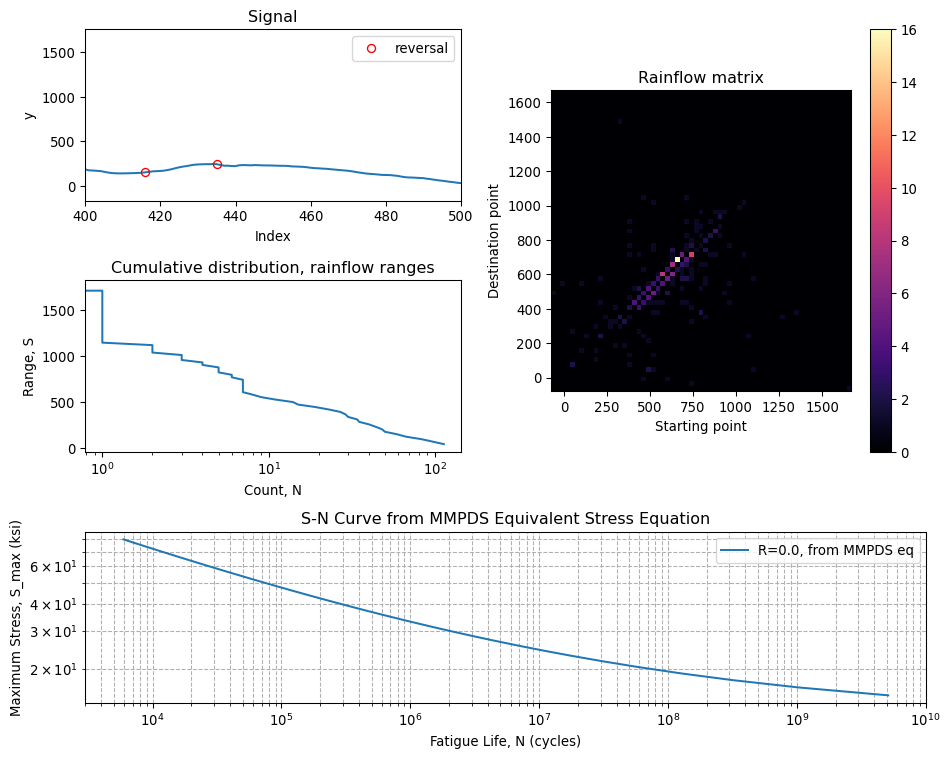

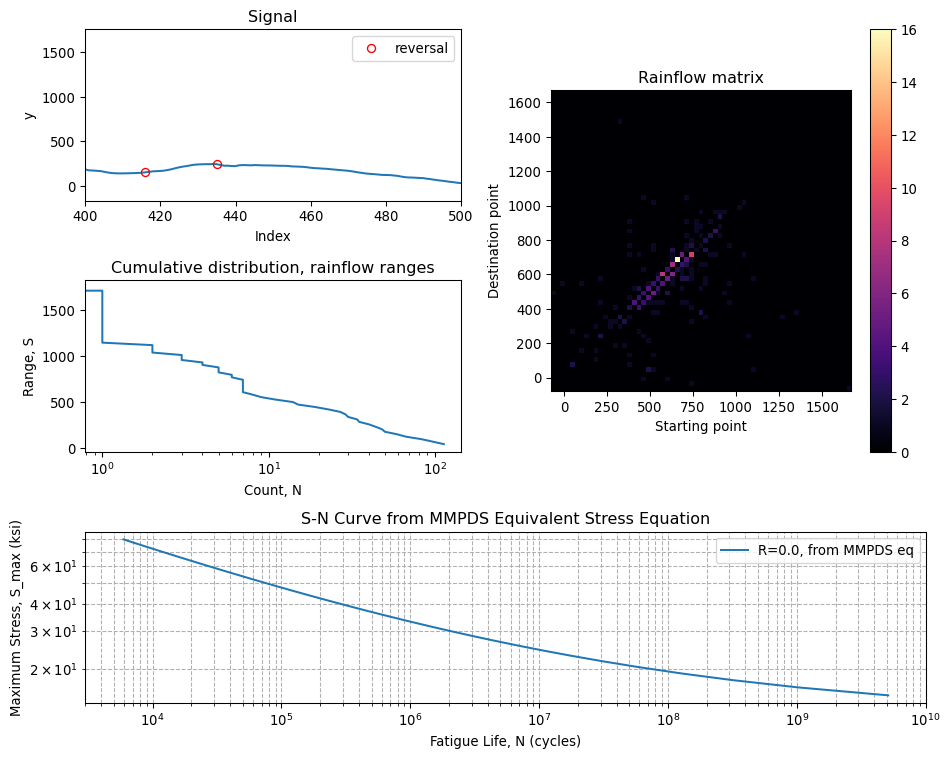

In [1]:
# -*- coding: utf-8 -*-
import wx
import wx.lib.filebrowsebutton as filebrowse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_wxagg import FigureCanvasWxAgg as FigureCanvas
import fatpack

# 定义S-N曲线类，将MMPDS给出的公式封装起来
class SNCurveMMPDS:
    def __init__(self, A=11.8, B=4.38, C=12.0, m=0.61):
        self.A = A
        self.B = B
        self.C = C
        self.m = m
    
    def S_eq(self, S_max, R):
        return S_max * (1 - R)**self.m
    
    def fatigue_life(self, S_max, R):
        seq = self.S_eq(S_max, R)
        if np.any(seq <= self.C):
            return np.full_like(seq, np.nan)
        logNf = self.A - self.B * np.log10(seq - self.C)
        Nf = 10**logNf
        return Nf

class MyFrame(wx.Frame):
    def __init__(self, parent, title="Fatigue Analysis GUI"):
        super(MyFrame, self).__init__(parent, title=title, size=(1000, 700))
        
        self.data = None  # 用于存储导入的CSV数据
        self.ranges = None
        self.init_ui()

    def init_ui(self):
        panel = wx.Panel(self)
        vbox = wx.BoxSizer(wx.VERTICAL)
        
        # 文件加载按钮
        hbox1 = wx.BoxSizer(wx.HORIZONTAL)
        load_btn = wx.Button(panel, label="加载数据(CSV)")
        load_btn.Bind(wx.EVT_BUTTON, self.on_load_data)
        hbox1.Add(load_btn, 0, wx.ALL, 5)
        
        # 显示图形按钮
        show_btn = wx.Button(panel, label="显示图形")
        show_btn.Bind(wx.EVT_BUTTON, self.on_show_plots)
        hbox1.Add(show_btn, 0, wx.ALL, 5)
        
        vbox.Add(hbox1, 0, wx.EXPAND|wx.ALL, 5)
        
        # 为后续Matplotlib嵌入提供面板（可选）
        self.plot_panel = wx.Panel(panel)
        vbox.Add(self.plot_panel, 1, wx.EXPAND|wx.ALL, 5)
        
        panel.SetSizer(vbox)
        self.Centre()

    def on_load_data(self, event):
        """从CSV文件导入数据"""
        with wx.FileDialog(self, "选择CSV文件", wildcard="CSV files (*.csv)|*.csv",
                           style=wx.FD_OPEN | wx.FD_FILE_MUST_EXIST) as fileDialog:

            if fileDialog.ShowModal() == wx.ID_CANCEL:
                return  # 用户取消
            
            pathname = fileDialog.GetPath()
            try:
                # 假设CSV文件有一列名为'y'的应力/信号数据
                df = pd.read_csv(pathname)
                # 确保有列'y'
                if 'y' not in df.columns:
                    wx.MessageBox("CSV中未找到名为'y'的列，请检查数据格式。", "错误", wx.ICON_ERROR)
                    return
                
                y = df['y'].values
                
                # 与原代码中处理相同：雨流计数处理
                reversals, reversals_ix = fatpack.find_reversals(y)
                cycles, residue = fatpack.find_rainflow_cycles(reversals)
                processed_residue = fatpack.concatenate_reversals(residue, residue)
                cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
                cycles_total = np.concatenate((cycles, cycles_residue))

                self.ranges = np.abs(cycles_total[:, 1] - cycles_total[:, 0])
                self.cycles_total = cycles_total
                self.data = y  # 存储原数据

                wx.MessageBox("数据加载成功！", "信息", wx.ICON_INFORMATION)
            except Exception as e:
                wx.MessageBox(f"加载数据失败: {e}", "错误", wx.ICON_ERROR)
    
    def on_show_plots(self, event):
        """显示图形：包括雨流分析图和S-N曲线图"""
        if self.data is None:
            wx.MessageBox("请先加载数据！", "错误", wx.ICON_ERROR)
            return
        
        # 创建一个Matplotlib figure进行绘图
        fig = plt.figure(figsize=(10, 8), dpi=96)
        
        # 子图1：Signal with reversals
        ax_signal = fig.add_subplot(3, 2, (1,1))
        y = self.data
        reversals_ix = fatpack.find_reversals(y)[1]
        ax_signal.plot(y)
        ax_signal.plot(reversals_ix, y[reversals_ix], 'ro', fillstyle='none', label='reversal')
        ax_signal.legend()
        ax_signal.set_title("Signal")
        ax_signal.set_ylabel("y")
        ax_signal.set_xlabel("Index")
        ax_signal.set_xlim([400, 500])
        
        # 子图2：Cumulative distribution
        ax_cumdist = fig.add_subplot(3, 2, (3,3))
        N, S = fatpack.find_range_count(self.ranges, 64)
        Ncum = N.sum() - np.cumsum(N)
        ax_cumdist.semilogx(Ncum, S)
        ax_cumdist.set_title("Cumulative distribution, rainflow ranges")
        ax_cumdist.set_xlabel("Count, N")
        ax_cumdist.set_ylabel("Range, S")
        
        # 子图3：Rainflow matrix
        ax_rfcmat = fig.add_subplot(3, 2, (2,4), aspect='equal')
        cycles_total = np.concatenate((fatpack.find_rainflow_cycles(fatpack.find_reversals(y)[0])[0],
                                       fatpack.find_rainflow_cycles(
                                           fatpack.concatenate_reversals(
                                               fatpack.find_rainflow_cycles(fatpack.find_reversals(y)[0])[1],
                                               fatpack.find_rainflow_cycles(fatpack.find_reversals(y)[0])[1]
                                           )
                                       )[0]))
        bins = np.linspace(cycles_total.min(), cycles_total.max(), 64)
        rfcmat = fatpack.find_rainflow_matrix(cycles_total, bins, bins)
        X, Y = np.meshgrid(bins, bins, indexing='ij')
        C = ax_rfcmat.pcolormesh(X, Y, rfcmat, cmap='magma')
        fig.colorbar(C, ax=ax_rfcmat)
        ax_rfcmat.set_title("Rainflow matrix")
        ax_rfcmat.set_xlabel("Starting point")
        ax_rfcmat.set_ylabel("Destination point")
        
        # 子图4：S-N曲线（使用SNCurveMMPDS类）
        ax_sn = fig.add_subplot(3, 2, (5,6))
        sn_curve = SNCurveMMPDS()  # 使用默认参数A,B,C,m
        R = 0.0
        S_max_values = np.linspace(15, 80, 50)
        Nf_values = sn_curve.fatigue_life(S_max_values, R)
        ax_sn.loglog(Nf_values, S_max_values, label=f'R={R}, from MMPDS eq')
        ax_sn.set_xlabel('Fatigue Life, N (cycles)')
        ax_sn.set_ylabel('Maximum Stress, S_max (ksi)')
        ax_sn.set_title('S-N Curve from MMPDS Equivalent Stress Equation')
        ax_sn.grid(which='both', linestyle='--')
        ax_sn.legend()
        
        # 将图形显示在新的窗口中（或者可嵌入GUI中）
        plt.tight_layout()
        plt.show()


class MyApp(wx.App):
    def OnInit(self):
        frame = MyFrame(None, "Fatigue Analysis with WX")
        frame.Show()
        return True

if __name__ == "__main__":
    app = MyApp(False)
    app.MainLoop()


In [3]:
# -*- coding: utf-8 -*-
import wx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_wxagg import FigureCanvasWxAgg as FigureCanvas
import fatpack

class SNCurveMMPDS:
    def __init__(self, A=11.8, B=4.38, C=12.0, m=0.61):
        self.A = A
        self.B = B
        self.C = C
        self.m = m
    
    def S_eq(self, S_max, R):
        return S_max * (1 - R)**self.m
    
    def fatigue_life(self, S_max, R):
        seq = self.S_eq(S_max, R)
        if np.any(seq <= self.C):
            return np.full_like(seq, np.nan)
        logNf = self.A - self.B * np.log10(seq - self.C)
        Nf = 10**logNf
        return Nf

class MyFrame(wx.Frame):
    def __init__(self, parent, title="Fatigue Analysis GUI"):
        super(MyFrame, self).__init__(parent, title=title, size=(1000, 700))
        
        self.data = None  # 原始数据（若需要用于雨流计数）
        self.x_data = None
        self.y_data = None
        self.ranges = None
        self.init_ui()

    def init_ui(self):
        panel = wx.Panel(self)
        vbox = wx.BoxSizer(wx.VERTICAL)
        
        # 文件加载按钮
        hbox1 = wx.BoxSizer(wx.HORIZONTAL)
        load_btn = wx.Button(panel, label="加载数据(CSV)")
        load_btn.Bind(wx.EVT_BUTTON, self.on_load_data)
        hbox1.Add(load_btn, 0, wx.ALL, 5)
        
        # 显示图形按钮（显示两列数据的折线图）
        show_btn = wx.Button(panel, label="显示折线图")
        show_btn.Bind(wx.EVT_BUTTON, self.on_show_line_plot)
        hbox1.Add(show_btn, 0, wx.ALL, 5)
        
        # 显示疲劳分析图形按钮（可选）
        show_fatigue_btn = wx.Button(panel, label="显示疲劳分析图")
        show_fatigue_btn.Bind(wx.EVT_BUTTON, self.on_show_plots)
        hbox1.Add(show_fatigue_btn, 0, wx.ALL, 5)
        
        vbox.Add(hbox1, 0, wx.EXPAND|wx.ALL, 5)
        
        # 为后续Matplotlib嵌入提供面板（如果需要）
        self.plot_panel = wx.Panel(panel)
        vbox.Add(self.plot_panel, 1, wx.EXPAND|wx.ALL, 5)
        
        panel.SetSizer(vbox)
        self.Centre()

    def on_load_data(self, event):
        """从CSV文件导入数据，并将第一列作为X轴，第二列作为Y轴"""
        with wx.FileDialog(self, "选择CSV文件", wildcard="CSV files (*.csv)|*.csv",
                           style=wx.FD_OPEN | wx.FD_FILE_MUST_EXIST) as fileDialog:

            if fileDialog.ShowModal() == wx.ID_CANCEL:
                return  # 用户取消
            
            pathname = fileDialog.GetPath()
            try:
                # 假设没有表头，用空白或逗号分隔，需要根据实际文件情况调整参数
                # 若文件以空格为分隔符，可添加 `sep='\s+'`参数
                df = pd.read_csv(pathname, header=None, delim_whitespace=True)
                
                # 取第一列为X，第二列为Y
                if df.shape[1] < 2:
                    wx.MessageBox("CSV文件数据列不足两列，请检查数据格式。", "错误", wx.ICON_ERROR)
                    return
                
                self.x_data = df.iloc[:, 0].values
                self.y_data = df.iloc[:, 1].values

                # 如需保留雨流计数功能，请在这里使用y_data进行后续处理，否则可注释
                y = self.y_data
                reversals, reversals_ix = fatpack.find_reversals(y)
                cycles, residue = fatpack.find_rainflow_cycles(reversals)
                processed_residue = fatpack.concatenate_reversals(residue, residue)
                cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
                cycles_total = np.concatenate((cycles, cycles_residue))
                self.ranges = np.abs(cycles_total[:, 1] - cycles_total[:, 0])
                self.data = y  # 原始信号数据保存
                
                wx.MessageBox("数据加载成功！", "信息", wx.ICON_INFORMATION)
            except Exception as e:
                wx.MessageBox(f"加载数据失败: {e}", "错误", wx.ICON_ERROR)
    
    def on_show_line_plot(self, event):
        """显示使用第一列X和第二列Y的数据折线图"""
        if self.x_data is None or self.y_data is None:
            wx.MessageBox("请先加载数据！", "错误", wx.ICON_ERROR)
            return
        
        fig, ax = plt.subplots(figsize=(8, 6), dpi=96)
        ax.plot(self.x_data, self.y_data, marker='o', linestyle='-', label='Data Line')
        
        # 根据数据范围自动调整轴范围
        x_min, x_max = np.min(self.x_data), np.max(self.x_data)
        y_min, y_max = np.min(self.y_data), np.max(self.y_data)
        
        # 给范围添加一定的边界余量
        x_margin = (x_max - x_min) * 0.05
        y_margin = (y_max - y_min) * 0.05
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
        
        ax.set_xlabel("X Value")
        ax.set_ylabel("Y Value")
        ax.set_title("Line Plot from CSV Data")
        ax.grid(True)
        ax.legend()
        
        plt.tight_layout()
        plt.show()

    def on_show_plots(self, event):
        """显示雨流计数和S-N曲线等图形（可选）"""
        if self.data is None:
            wx.MessageBox("请先加载数据！", "错误", wx.ICON_ERROR)
            return
        
        y = self.data
        fig = plt.figure(figsize=(10, 8), dpi=96)
        
        # 子图1：Signal with reversals
        ax_signal = fig.add_subplot(3, 2, (1,1))
        reversals_ix = fatpack.find_reversals(y)[1]
        ax_signal.plot(y)
        ax_signal.plot(reversals_ix, y[reversals_ix], 'ro', fillstyle='none', label='reversal')
        ax_signal.legend()
        ax_signal.set_title("Signal")
        ax_signal.set_ylabel("y")
        ax_signal.set_xlabel("Index")
        
        # 子图2：Cumulative distribution
        ax_cumdist = fig.add_subplot(3, 2, (3,3))
        N, S = fatpack.find_range_count(self.ranges, 64)
        Ncum = N.sum() - np.cumsum(N)
        ax_cumdist.semilogx(Ncum, S)
        ax_cumdist.set_title("Cumulative distribution, rainflow ranges")
        ax_cumdist.set_xlabel("Count, N")
        ax_cumdist.set_ylabel("Range, S")
        
        # 子图3：Rainflow matrix
        ax_rfcmat = fig.add_subplot(3, 2, (2,4), aspect='equal')
        # 因数据已处理可直接使用self.data和相关计算，如下：
        reversals, reversals_ix = fatpack.find_reversals(y)
        cycles, residue = fatpack.find_rainflow_cycles(reversals)
        processed_residue = fatpack.concatenate_reversals(residue, residue)
        cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
        cycles_total = np.concatenate((cycles, cycles_residue))

        bins = np.linspace(cycles_total.min(), cycles_total.max(), 64)
        rfcmat = fatpack.find_rainflow_matrix(cycles_total, bins, bins)
        X, Y = np.meshgrid(bins, bins, indexing='ij')
        C = ax_rfcmat.pcolormesh(X, Y, rfcmat, cmap='magma')
        fig.colorbar(C, ax=ax_rfcmat)
        ax_rfcmat.set_title("Rainflow matrix")
        ax_rfcmat.set_xlabel("Starting point")
        ax_rfcmat.set_ylabel("Destination point")
        
        # 子图4：S-N曲线
        ax_sn = fig.add_subplot(3, 2, (5,6))
        sn_curve = SNCurveMMPDS()  # 使用默认参数A,B,C,m
        R = 0.0
        S_max_values = np.linspace(15, 80, 50)
        Nf_values = sn_curve.fatigue_life(S_max_values, R)
        ax_sn.loglog(Nf_values, S_max_values, label=f'R={R}, from MMPDS eq')
        ax_sn.set_xlabel('Fatigue Life, N (cycles)')
        ax_sn.set_ylabel('Maximum Stress, S_max (ksi)')
        ax_sn.set_title('S-N Curve from MMPDS Equivalent Stress Equation')
        ax_sn.grid(which='both', linestyle='--')
        ax_sn.legend()
        
        plt.tight_layout()
        plt.show()

class MyApp(wx.App):
    def OnInit(self):
        frame = MyFrame(None, "Fatigue Analysis with WX")
        frame.Show()
        return True

if __name__ == "__main__":
    app = MyApp(False)
    app.MainLoop()


C:\Users\wendy\AppData\Local\Temp\ipykernel_18096\2884528501.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(pathname, header=None, delim_whitespace=True)
C:\Users\wendy\AppData\Local\Temp\ipykernel_18096\2884528501.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(pathname, header=None, delim_whitespace=True)


In [ ]:
# -*- coding: utf-8 -*-
import wx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_wxagg import FigureCanvasWxAgg as FigureCanvas
import fatpack

class SNCurveMMPDS:
    def __init__(self, A=11.8, B=4.38, C=12.0, m=0.61):
        self.A = A
        self.B = B
        self.C = C
        self.m = m
    
    def S_eq(self, S_max, R):
        return S_max * (1 - R)**self.m
    
    def fatigue_life(self, S_max, R):
        seq = self.S_eq(S_max, R)
        if np.any(seq <= self.C):
            return np.full_like(seq, np.nan)
        logNf = self.A - self.B * np.log10(seq - self.C)
        Nf = 10**logNf
        return Nf

class MyFrame(wx.Frame):
    def __init__(self, parent, title="Fatigue Analysis GUI"):
        super(MyFrame, self).__init__(parent, title=title, size=(1000, 700))
        
        self.data = None  # 原始数据（若需要用于雨流计数）
        self.x_data = None
        self.y_data = None
        self.ranges = None
        self.init_ui()

    def init_ui(self):
        panel = wx.Panel(self)
        vbox = wx.BoxSizer(wx.VERTICAL)
        
        # 文件加载按钮
        hbox1 = wx.BoxSizer(wx.HORIZONTAL)
        load_btn = wx.Button(panel, label="加载数据(TXT)")
        load_btn.Bind(wx.EVT_BUTTON, self.on_load_data)
        hbox1.Add(load_btn, 0, wx.ALL, 5)
        
        # 显示图形按钮（显示两列数据的折线图）
        show_btn = wx.Button(panel, label="显示折线图")
        show_btn.Bind(wx.EVT_BUTTON, self.on_show_line_plot)
        hbox1.Add(show_btn, 0, wx.ALL, 5)
        
        # 显示疲劳分析图形按钮（可选）
        show_fatigue_btn = wx.Button(panel, label="显示疲劳分析图")
        show_fatigue_btn.Bind(wx.EVT_BUTTON, self.on_show_plots)
        hbox1.Add(show_fatigue_btn, 0, wx.ALL, 5)
        
        vbox.Add(hbox1, 0, wx.EXPAND|wx.ALL, 5)
        
        # 为后续Matplotlib嵌入提供面板（如果需要）
        self.plot_panel = wx.Panel(panel)
        vbox.Add(self.plot_panel, 1, wx.EXPAND|wx.ALL, 5)
        
        panel.SetSizer(vbox)
        self.Centre()

    def on_load_data(self, event):
        """从TXT文件导入数据，并将第一列作为X轴(时间)，第二列作为Y轴(应力)"""
        with wx.FileDialog(self, "选择TXT文件", wildcard="TXT files (*.txt)|*.txt",
                           style=wx.FD_OPEN | wx.FD_FILE_MUST_EXIST) as fileDialog:

            if fileDialog.ShowModal() == wx.ID_CANCEL:
                return  # 用户取消
            
            pathname = fileDialog.GetPath()
            try:
                # 假设txt文件中两列数据由空白分隔（空格、tab等），无表头
                df = pd.read_csv(pathname, header=None, delim_whitespace=True)
                
                # 取第一列为X(时间)，第二列为Y(应力)
                if df.shape[1] < 2:
                    wx.MessageBox("TXT文件数据列不足两列，请检查数据格式。", "错误", wx.ICON_ERROR)
                    return
                
                self.x_data = df.iloc[:, 0].values
                self.y_data = df.iloc[:, 1].values

                # 可选：进行雨流计数分析（如需保留原逻辑）
                y = self.y_data
                reversals, reversals_ix = fatpack.find_reversals(y)
                cycles, residue = fatpack.find_rainflow_cycles(reversals)
                processed_residue = fatpack.concatenate_reversals(residue, residue)
                cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
                cycles_total = np.concatenate((cycles, cycles_residue))
                self.ranges = np.abs(cycles_total[:, 1] - cycles_total[:, 0])
                self.data = y  # 原始信号数据保存
                
                wx.MessageBox("数据加载成功！", "信息", wx.ICON_INFORMATION)
            except Exception as e:
                wx.MessageBox(f"加载数据失败: {e}", "错误", wx.ICON_ERROR)
    
    def on_show_line_plot(self, event):
        """显示使用txt文件第一列X(时间)和第二列Y(应力)的数据折线图"""
        if self.x_data is None or self.y_data is None:
            wx.MessageBox("请先加载数据！", "错误", wx.ICON_ERROR)
            return
        
        fig, ax = plt.subplots(figsize=(8, 6), dpi=96)
        ax.plot(self.x_data, self.y_data, marker='o', linestyle='-', label='Time-Stress Data')
        
        # 根据数据范围自动调整轴范围
        x_min, x_max = np.min(self.x_data), np.max(self.x_data)
        y_min, y_max = np.min(self.y_data), np.max(self.y_data)
        
        # 给范围添加一定的边界余量
        x_margin = (x_max - x_min) * 0.05 if (x_max - x_min) != 0 else 1.0
        y_margin = (y_max - y_min) * 0.05 if (y_max - y_min) != 0 else 1.0
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
        
        ax.set_xlabel("Time")
        ax.set_ylabel("Stress")
        ax.set_title("Line Plot from TXT Data (Time vs Stress)")
        ax.grid(True)
        ax.legend()
        
        plt.tight_layout()
        plt.show()

    def on_show_plots(self, event):
        """显示雨流计数和S-N曲线等图形（可选）"""
        if self.data is None:
            wx.MessageBox("请先加载数据！", "错误", wx.ICON_ERROR)
            return
        
        y = self.data
        fig = plt.figure(figsize=(10, 8), dpi=96)
        
        # 子图1：Signal with reversals
        ax_signal = fig.add_subplot(3, 2, (1,1))
        reversals_ix = fatpack.find_reversals(y)[1]
        ax_signal.plot(y)
        ax_signal.plot(reversals_ix, y[reversals_ix], 'ro', fillstyle='none', label='reversal')
        ax_signal.legend()
        ax_signal.set_title("Signal")
        ax_signal.set_ylabel("y")
        ax_signal.set_xlabel("Index")
        
        # 子图2：Cumulative distribution
        ax_cumdist = fig.add_subplot(3, 2, (3,3))
        N, S = fatpack.find_range_count(self.ranges, 64)
        Ncum = N.sum() - np.cumsum(N)
        ax_cumdist.semilogx(Ncum, S)
        ax_cumdist.set_title("Cumulative distribution, rainflow ranges")
        ax_cumdist.set_xlabel("Count, N")
        ax_cumdist.set_ylabel("Range, S")
        
        # 子图3：Rainflow matrix
        ax_rfcmat = fig.add_subplot(3, 2, (2,4), aspect='equal')
        reversals, reversals_ix = fatpack.find_reversals(y)
        cycles, residue = fatpack.find_rainflow_cycles(reversals)
        processed_residue = fatpack.concatenate_reversals(residue, residue)
        cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
        cycles_total = np.concatenate((cycles, cycles_residue))

        bins = np.linspace(cycles_total.min(), cycles_total.max(), 64)
        rfcmat = fatpack.find_rainflow_matrix(cycles_total, bins, bins)
        X, Y = np.meshgrid(bins, bins, indexing='ij')
        C = ax_rfcmat.pcolormesh(X, Y, rfcmat, cmap='magma')
        fig.colorbar(C, ax=ax_rfcmat)
        ax_rfcmat.set_title("Rainflow matrix")
        ax_rfcmat.set_xlabel("Starting point")
        ax_rfcmat.set_ylabel("Destination point")
        
        # 子图4：S-N曲线
        ax_sn = fig.add_subplot(3, 2, (5,6))
        sn_curve = SNCurveMMPDS()  # 使用默认参数A,B,C,m
        R = 0.0
        S_max_values = np.linspace(15, 80, 50)
        Nf_values = sn_curve.fatigue_life(S_max_values, R)
        ax_sn.loglog(Nf_values, S_max_values, label=f'R={R}, from MMPDS eq')
        ax_sn.set_xlabel('Fatigue Life, N (cycles)')
        ax_sn.set_ylabel('Maximum Stress, S_max (ksi)')
        ax_sn.set_title('S-N Curve from MMPDS Equivalent Stress Equation')
        ax_sn.grid(which='both', linestyle='--')
        ax_sn.legend()
        
        plt.tight_layout()
        plt.show()

class MyApp(wx.App):
    def OnInit(self):
        frame = MyFrame(None, "Fatigue Analysis with WX")
        frame.Show()
        return True

if __name__ == "__main__":
    app = MyApp(False)
    app.MainLoop()


PyNoAppError: The wx.App object must be created first!

C:\Users\wendy\AppData\Local\Temp\ipykernel_3620\1045719272.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, header=None, delim_whitespace=True)


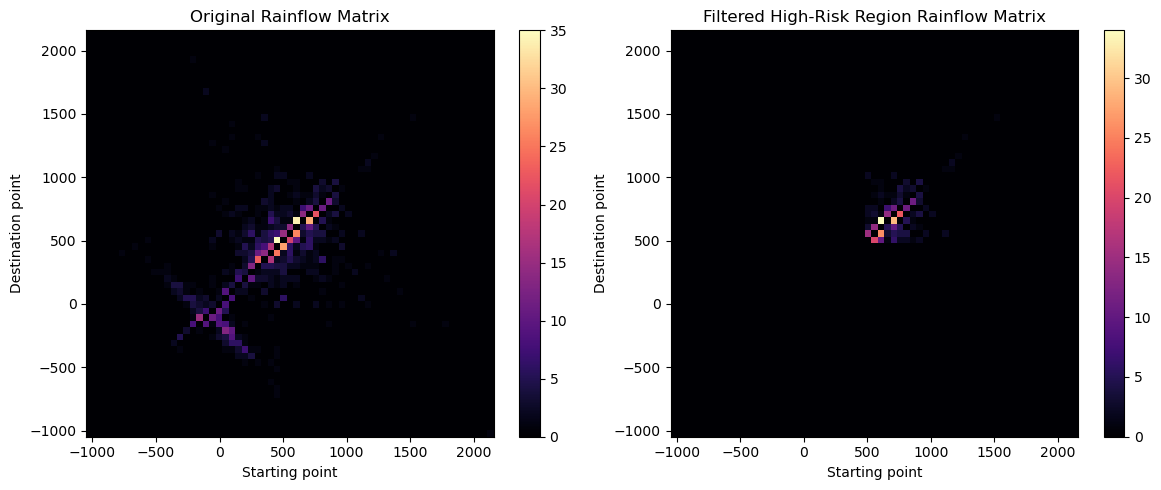

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fatpack

# 参数设置
threshold = 500.0  # 定义高风险区域的阈值，比如应力大于500的循环认为是高风险
num_bins = 64      # Rainflow矩阵的分箱数

# 从TXT文件导入数据，假设文件中有两列，第一列是时间，第二列是应力
# 如果只有一列应力数据,则可以用 df = pd.read_csv('data.txt', header=None, delim_whitespace=True); y = df[0].values
txt_file = "C:/From QQ/9号/roadmap/Fz.txt"  # 请替换为你的TXT文件名
df = pd.read_csv(txt_file, header=None, delim_whitespace=True)

# 假设第二列为应力数据
y = df.iloc[:,1].values  # 若只有一列数据，用 df.iloc[:,0].values

# 使用fatpack进行雨流计数分析
# 1. 寻找反转点（reversals）
reversals, reversals_ix = fatpack.find_reversals(y)

# 2. 寻找雨流循环
cycles, residue = fatpack.find_rainflow_cycles(reversals)
processed_residue = fatpack.concatenate_reversals(residue, residue)
cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)

# 合并得到完整的cycles数据
cycles_total = np.concatenate((cycles, cycles_residue))

# 绘制原始雨流图前，先计算rainflow matrix
bins = np.linspace(cycles_total.min(), cycles_total.max(), num_bins)

# 原始的rainflow矩阵
rfcmat_original = fatpack.find_rainflow_matrix(cycles_total, bins, bins)

# 使用中点坐标来生成与rfcmat维度匹配的X,Y
x_centers = (bins[:-1] + bins[1:]) / 2.0
X, Y = np.meshgrid(x_centers, x_centers, indexing='ij')

# 绘制原始雨流图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

c1 = ax1.pcolormesh(X, Y, rfcmat_original, cmap='magma')
fig.colorbar(c1, ax=ax1)
ax1.set_title("Original Rainflow Matrix")
ax1.set_xlabel("Starting point")
ax1.set_ylabel("Destination point")

# 根据高风险区域条件筛选循环
# 假设高风险区域定义为：起点和终点应力都大于threshold
high_risk_mask = (cycles_total[:,0] > threshold) & (cycles_total[:,1] > threshold)
high_risk_cycles = cycles_total[high_risk_mask]

if len(high_risk_cycles) > 0:
    rfcmat_hr = fatpack.find_rainflow_matrix(high_risk_cycles, bins, bins)
    c2 = ax2.pcolormesh(X, Y, rfcmat_hr, cmap='magma')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title("Filtered High-Risk Region Rainflow Matrix")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")
else:
    # 若无高风险循环，则可显示提示
    ax2.text(0.5, 0.5, "No cycles in high-risk region.", ha='center', va='center')
    ax2.set_title("Filtered High-Risk Region Rainflow Matrix")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")

plt.tight_layout()
plt.show()


C:\Users\wendy\AppData\Local\Temp\ipykernel_3620\3908754012.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, header=None, delim_whitespace=True)


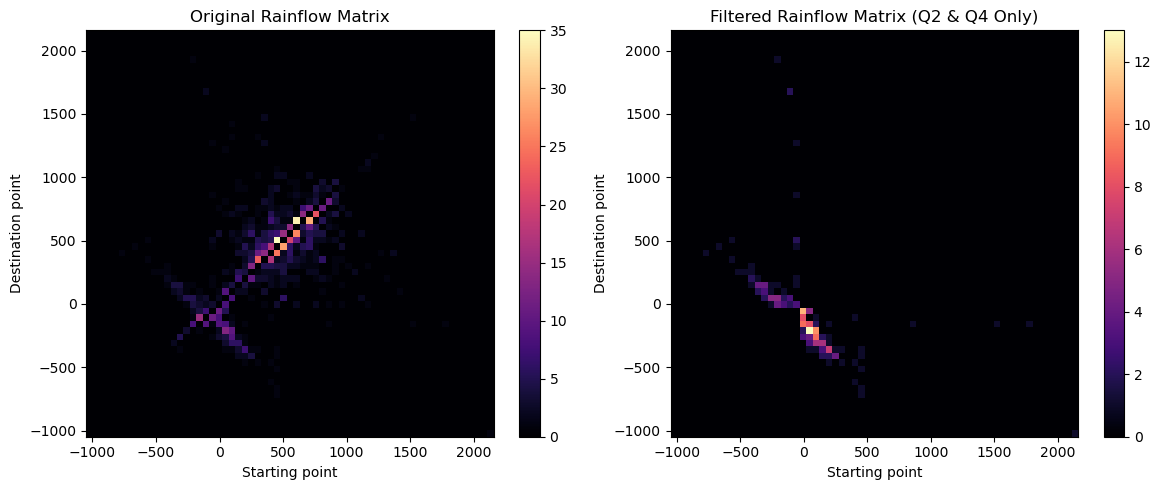

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fatpack

# 从TXT文件读取数据
txt_file = 'C:/From QQ/9号/roadmap/Fz.txt'  # 请替换为你的TXT文件名
# 假设TXT文件有两列数据：第一列为时间，第二列为应力
df = pd.read_csv(txt_file, header=None, delim_whitespace=True)
y = df.iloc[:,1].values  # 使用第二列作为应力数据

# 进行雨流计数分析
reversals, reversals_ix = fatpack.find_reversals(y)
cycles, residue = fatpack.find_rainflow_cycles(reversals)
processed_residue = fatpack.concatenate_reversals(residue, residue)
cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)

# 合并所有cycle数据
cycles_total = np.concatenate((cycles, cycles_residue))

# 定义rainflow matrix的分箱
num_bins = 64
bins = np.linspace(cycles_total.min(), cycles_total.max(), num_bins)

# 计算原始rainflow matrix
rfcmat_original = fatpack.find_rainflow_matrix(cycles_total, bins, bins)

# 使用中点坐标以匹配rfcmat形状
x_centers = (bins[:-1] + bins[1:]) / 2.0
X, Y = np.meshgrid(x_centers, x_centers, indexing='ij')

# 绘制原始雨流图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

c1 = ax1.pcolormesh(X, Y, rfcmat_original, cmap='magma')
fig.colorbar(c1, ax=ax1)
ax1.set_title("Original Rainflow Matrix")
ax1.set_xlabel("Starting point")
ax1.set_ylabel("Destination point")

# 根据象限过滤数据：仅保留第二和第四象限
# Q2: start<0, end>0
# Q4: start>0, end<0
start = cycles_total[:,0]
end = cycles_total[:,1]
q2_or_q4_mask = ((start < 0) & (end > 0)) | ((start > 0) & (end < 0))
filtered_cycles = cycles_total[q2_or_q4_mask]

if len(filtered_cycles) > 0:
    rfcmat_filtered = fatpack.find_rainflow_matrix(filtered_cycles, bins, bins)
    c2 = ax2.pcolormesh(X, Y, rfcmat_filtered, cmap='magma')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title("Filtered Rainflow Matrix (Q2 & Q4 Only)")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")
else:
    # 若无满足条件的循环则显示信息
    ax2.text(0.5, 0.5, "No Q2/Q4 cycles found.", ha='center', va='center')
    ax2.set_title("Filtered Rainflow Matrix (Q2 & Q4 Only)")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")

plt.tight_layout()
plt.show()


C:\Users\wendy\AppData\Local\Temp\ipykernel_3620\1062665095.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, header=None, delim_whitespace=True)


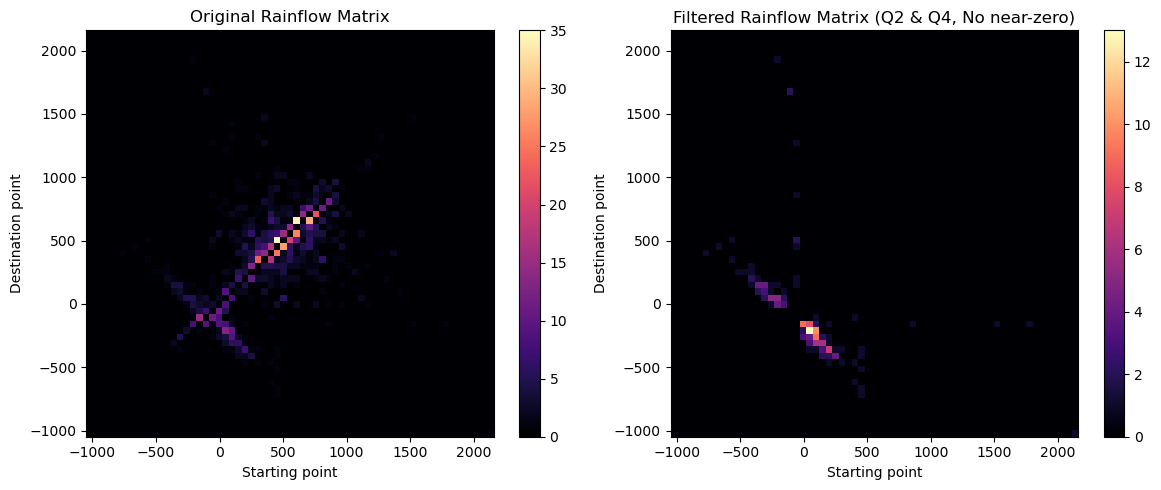

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fatpack

# 从TXT文件读取数据
txt_file = 'C:/From QQ/9号/roadmap/Fz.txt'  # 请替换为你的TXT文件名
df = pd.read_csv(txt_file, header=None, delim_whitespace=True)

# 假设第二列为应力数据
y = df.iloc[:,1].values

# 雨流计数分析
reversals, reversals_ix = fatpack.find_reversals(y)
cycles, residue = fatpack.find_rainflow_cycles(reversals)
processed_residue = fatpack.concatenate_reversals(residue, residue)
cycles_residue, _ = fatpack.find_rainflow_cycles(processed_residue)
cycles_total = np.concatenate((cycles, cycles_residue))

# 定义分箱数和bins
num_bins = 64
bins = np.linspace(cycles_total.min(), cycles_total.max(), num_bins)

# 原始Rainflow矩阵
rfcmat_original = fatpack.find_rainflow_matrix(cycles_total, bins, bins)

# 使用中点坐标匹配rfcmat形状
x_centers = (bins[:-1] + bins[1:]) / 2.0
X, Y = np.meshgrid(x_centers, x_centers, indexing='ij')

# 绘制原始雨流图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
c1 = ax1.pcolormesh(X, Y, rfcmat_original, cmap='magma')
fig.colorbar(c1, ax=ax1)
ax1.set_title("Original Rainflow Matrix")
ax1.set_xlabel("Starting point")
ax1.set_ylabel("Destination point")

# 根据象限过滤数据：仅保留第二(Q2)和第四(Q4)象限的循环
start = cycles_total[:,0]
end = cycles_total[:,1]
q2_or_q4_mask = ((start < 0) & (end > 0)) | ((start > 0) & (end < 0))
filtered_cycles = cycles_total[q2_or_q4_mask]

# 去除接近(0,0)附近的数据
# 根据需求设定阈值，如这里将非常接近零(±10范围内)视为低幅循环忽略
zero_threshold = 100.0
not_near_zero_mask = ~((np.abs(filtered_cycles[:,0]) < zero_threshold) & (np.abs(filtered_cycles[:,1]) < zero_threshold))
final_filtered_cycles = filtered_cycles[not_near_zero_mask]

# 如需导出最终过滤的数据到TXT文件
np.savetxt('C:/From QQ/9号/roadmap/filtered_cycles.txt', final_filtered_cycles, fmt='%.6f', delimiter=' ')

# 使用最终过滤后的数据计算rainflow矩阵并绘图
if len(final_filtered_cycles) > 0:
    rfcmat_filtered = fatpack.find_rainflow_matrix(final_filtered_cycles, bins, bins)
    c2 = ax2.pcolormesh(X, Y, rfcmat_filtered, cmap='magma')
    fig.colorbar(c2, ax=ax2)
    ax2.set_title("Filtered Rainflow Matrix (Q2 & Q4, No near-zero)")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")
else:
    # 若无符合条件的循环则提示
    ax2.text(0.5, 0.5, "No Q2/Q4 and non-near-zero cycles found.", ha='center', va='center')
    ax2.set_title("Filtered Rainflow Matrix (Q2 & Q4, No near-zero)")
    ax2.set_xlabel("Starting point")
    ax2.set_ylabel("Destination point")

plt.tight_layout()
plt.show()
